In [13]:
# work environment: jl2815
# Standard libraries
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import smoothspace

import pickle

# Summary

In this experiment, we assess how the Vecchia approximation is accurate by comparing two normalized values:

$ \frac{ Prediction(full)- \mu(full)} {\sigma(full)}$ vs $ \frac{ Prediction(full) - \mu(vecchia)} {\sigma(vecchia)}.$

To elaborate on second term; if $x_j$ is conditioned on $x_{i1},...,x_{i10},$ then I use these 10 points to calculate the coefficient for BLP and others instead of using the entire $x_1,..., x_{j-1}, x_{j+1},..., x_n$.

First one is supposed to be normal, and if the vecchia approximation is good enough approximating the full covariance structure, then we expect the second to be nearly standard normal as well. 

However that is not the case. This is because Vecchia approximation results in smaller standard deviation because it chooses the most relevant set as conditioning set, not the entire past data. 

--> Based on this experiment, I plan to clip the conditional standard deviation by  max(sd, 7), where 7 represents the general conditional standard deviation. 

#### Data setup

I picked a time with 20,000 data points. Then I chose a coarse set by choosing every 5th point both in latitude and longitude resulting in 800 data points. 

In [ ]:
lat_lon_resolution = [5,5]
mm_cond_number = 10
params= [60, 5.25, 5.25, 0.2, 0.5, 5]
key_for_dict= 5


# Load the one dictionary to set spaital coordinates
filepath = "C:/Users/joonw/TCO/data_engineering/data_2023/sparse_cen_map23_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        filepath = f"C:/Users/joonw/TCO/data_engineering/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata()
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)



analysis_data_map = {}
for i in range(key_for_dict):
    tmp = coarse_dicts[key_idx[i]]
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range((key_for_dict)):
    tmp = coarse_dicts[key_idx[i]]
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)


print(f'Aggregated data shape: {aggregated_data.shape}')
# print(aggregated_data.to_string())

Aggregated data shape: (4000, 5)


In [453]:
data = coarse_dicts['2024_07_y24m07day01_hm02:00']
data_copy = data.copy(deep=True)
instance = kernels.matern_spatio_temporal(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)
# data = data.iloc[ord, :]

cov_mat= instance.matern_cov_yx( params, data,data)
cov_mat.shape

(800, 800)

In [ ]:
nns_map = list(nns_map) # nns_map is ndarray this allows to have sub array of diffrent lengths
for i in range(len(nns_map)):  
    # Select elements up to mm_cond_number and remove -1
    tmp = np.delete(nns_map[i][:mm_cond_number], np.where(nns_map[i][:mm_cond_number] == -1))
    if tmp.size>0:
        nns_map[i] = tmp
    else:
        nns_map[i] = []

# Full vs Vecchia Normalization

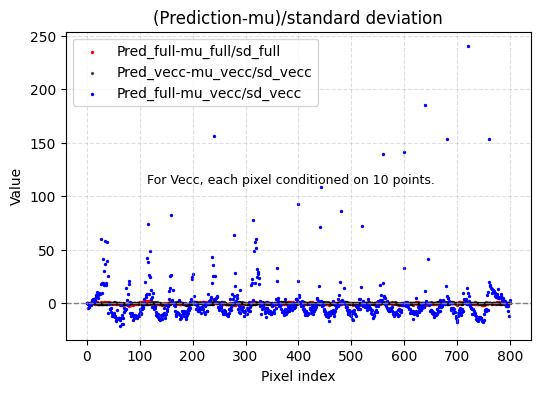

In [ ]:
n = len(cov_mat)
out_full = [0] * n
out_vecc = [0] * n
out_vecc_full = [0] * n

avg_full = [0] * n
avg_vecc = [0] * n
sd_full = [0] * n
sd_vecc = [0] * n


for j in range(2, n):
    data = data_copy.copy(deep=True)
    data = data.reset_index(drop=True)
    n = len(cov_mat)

    lin_coef = list(range(n))
    lin_coef.remove(j)

    lin_coef2 = list(range(j, 0, -1)) + list(range(1, n - j))

    sigma = cov_mat.iloc[lin_coef, lin_coef]
    gamma = cov_mat.iloc[0, lin_coef2]
    coef = np.linalg.solve(sigma, gamma)

    x_data = data['ColumnAmountO3']
    x_data.pop(j)

    avg_full[j] = np.dot(coef.T, np.ones(coef.shape) * np.mean(x_data))
    predictor_full = np.dot(coef.T, x_data)

    sd_full[j] = np.sqrt(np.dot(gamma.T, coef))

    out_full[j] = (predictor_full - avg_full[j]) / sd_full[j]

    ##################################

    d2 = data.iloc[[j] + list(nns_map[j]), :]
    cov = instance.matern_cov_yx(params, d2, d2)

    
    sigma = cov.iloc[1:, 1:]
    gamma = cov.iloc[0, 1:]
    coef_vecc = np.linalg.solve(sigma, gamma)

    x_data_vecc = d2['ColumnAmountO3']
    x_data_vecc.pop(j)

    avg_vecc[j] = np.dot(coef_vecc.T, np.ones(coef_vecc.shape) * np.mean(x_data_vecc))
    predictor_vecc = np.dot(coef_vecc.T, x_data_vecc)
    sd_vecc[j] = np.sqrt(np.dot(gamma.T, coef_vecc))

    out_vecc[j] = (predictor_vecc - avg_vecc[j] ) / (sd_vecc[j] )
    out_vecc_full[j] = (predictor_full - avg_vecc[j] ) / (sd_vecc[j] )
   
# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(range(len(out_full)), out_full, s=2, color='red', label='Pred_full-mu_full/sd_full')
plt.scatter(range(len(out_vecc)), out_vecc, s=2, color='black', label='Pred_vecc-mu_vecc/sd_vecc', alpha=0.6)

plt.scatter(range(len(out_vecc)), out_vecc_full, s=2, color='blue', label='Pred_full-mu_vecc/sd_vecc')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Pixel index')
plt.ylabel('Value')
plt.legend()
plt.title('(Prediction-mu)/standard deviation')
plt.grid(True, linestyle='--', alpha=0.4)
plt.figtext(0.5, 0.5, 'For Vecc, each pixel conditioned on 10 points.', ha='center', fontsize=9, color='black')
plt.show()

It seems they are quite different, let's see how sds and means behave.

The sd and mean plots show that the performance of kriging vary by predicting location. Generally it is good for interpolating. 

I think it makes sense that Vecchia results in smaller standard deviation because it chooses the most relevant set as conditioning set, not the entire past data. 

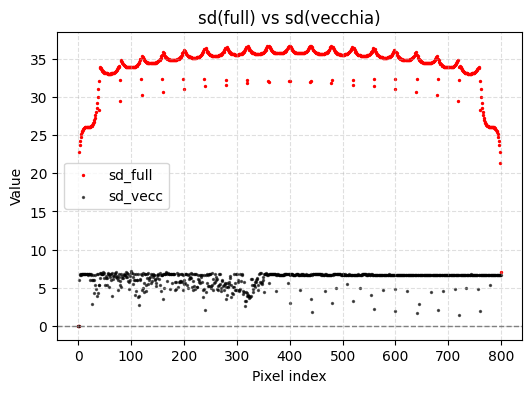

In [462]:
# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(range(len(sd_full)), sd_full, s=2, color='red', label='sd_full')
plt.scatter(range(len(sd_vecc)), sd_vecc, s=2, color='black', label='sd_vecc', alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Pixel index')
plt.ylabel('Value')
plt.legend()
plt.title('sd(full) vs sd(vecchia)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

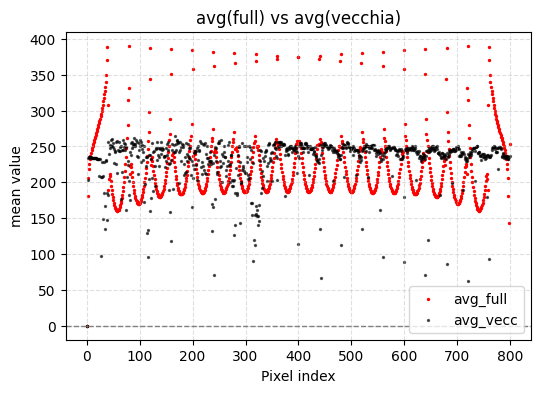

In [464]:
# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(range(len(avg_full)), avg_full, s=2, color='red', label='avg_full')
plt.scatter(range(len(avg_vecc)), avg_vecc, s=2, color='black', label='avg_vecc', alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Pixel index')
plt.ylabel('mean value')
plt.legend()
plt.title('avg(full) vs avg(vecchia)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Reference 

# Full covariance matrix

We can see that the normalized value using the full data looks like standard normal.

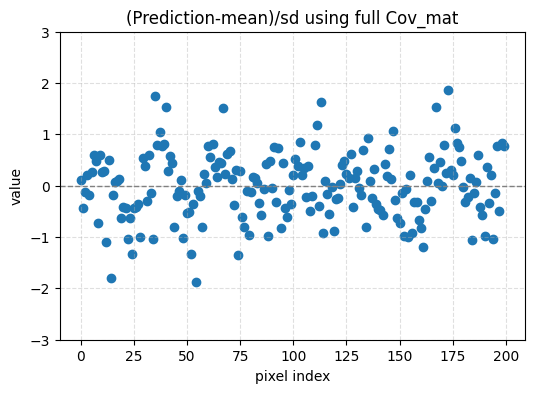

In [465]:
n = len(cov_mat)
out_full = [0]*n
for j in range(n):
    data = data_copy.copy(deep=True)
    data = data.reset_index(drop=True)
    n = len(cov_mat)

    lin_coef = list(range(n))
    lin_coef.remove(j)

    lin_coef2 = list(range(j,0,-1)) + list(range(1, (n-j)))
    lin_coef2

    # print(np.sum(cov_mat))

    sigma = cov_mat.iloc[lin_coef, lin_coef]
    gamma = cov_mat.iloc[0, lin_coef2]

    coef = np.linalg.solve(sigma, gamma )
    # print( np.mean ( data['ColumnAmountO3']))
    # x_data = data['ColumnAmountO3'] - np.mean(data['ColumnAmountO3'])
    x_data = data['ColumnAmountO3']
    x_data.pop(j)

    x_mean_full  = np.dot(coef.T, np.ones( coef.shape)* np.mean(x_data))
    predictor_full = np.dot(coef.T,x_data)

    sd_full = np.sqrt(np.dot(gamma.T,coef))

    out_full[j] = (predictor_full- x_mean_full)/sd_full


# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(list(range(len(out))),out)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('pixel index')
plt.ylabel('value')
plt.ylim(-3,3)
plt.title('(Prediction-mean)/sd using full Cov_mat')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()




# Vecchia approximation

One observation is that normalized value has smaller standard deviation compared to the normalized value above using the full data. 

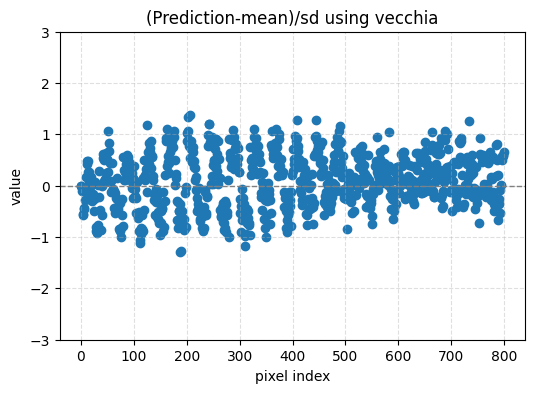

In [466]:
n = len(cov_mat)
out = [0]*n
for j in range(2,n):
    data = data_copy.copy(deep=True)
    n = len(cov_mat)

    d2 = data.iloc[(list([j])+ list(nns_map[j])),:]
    
    cov = instance.matern_cov_yx( params, d2,d2)
    # print(np.sum(cov_mat))

    sigma = cov.iloc[1:,1:]
    gamma = cov.iloc[0, 1:]
  
    coef = np.linalg.solve(sigma, gamma )

    demean_data = d2['ColumnAmountO3'] - np.mean(d2['ColumnAmountO3'])
    
    demean_data = d2['ColumnAmountO3']
    demean_data.pop(j)
    predictor = demean_data - np.mean (d2['ColumnAmountO3'])

    sd = np.sqrt(np.dot(gamma.T,coef))

    out[j] = np.dot(coef.T, predictor)/sd

# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(list(range(len(out))),out)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('pixel index')
plt.ylabel('value')
plt.ylim(-3,3)
plt.title('(Prediction-mean)/sd using vecchia')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()